# Assignment 5
## Word class prediction with neural networks
The assignment and data are available here: https://snlp2018.github.io/assignments.html

The file `data/train.txt` (and `test.txt` as well) contains a two-column, tab-separated dataset of German words, either nouns or verbs, each with its class label. We train a character-level neutral network to learn the word classes.

### Exercise 1
Data pre-processing. Read the data and encode as follows: target labels as 0s and 1s;  word characters to integers and words to lists of integers.

First, read data:

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_csv("data/train.txt", sep = "\t", names = ["class", "word"])
df_train.head()

,class,word
0,noun,gemeinderat
1,noun,grenzpolizei
2,verb,ruinieren
3,noun,halbtönen
4,noun,energieexporteuren


In [3]:
df_test = pd.read_csv("data/test.txt", sep = "\t", names = ["class", "word"])
df_test.head()

,class,word
0,noun,kaufverpflichtung
1,verb,kosten
2,noun,n
3,noun,blousons
4,noun,verwaltungsgeschäfte


Next, encode `class`; convention: `noun` -> `0`; `verb` -> `1`

In [4]:
train_y = np.where(df_train["class"] == "noun", 0, 1)
train_y[0:5]

array([0, 0, 1, 0, 0])

In [5]:
test_y = np.where(df_test["class"] == "noun", 0, 1)
test_y[0:5]

array([0, 1, 0, 0, 0])

Next, extract alphabet of Unicode characters from `df_train["words"]` and map each to an integer (its position in the list will do):

In [6]:
alphabet = list(set([c for word in [list(str(word)) for word in df_train["word"].tolist()] for c in word]))

In [7]:
print(alphabet)
print(len(alphabet))

['a', 'b', 'm', 'ß', 'j', 'u', 'x', 's', 'g', 'e', 'y', 'k', 'w', 'q', 'p', 'h', 'd', 'v', 'f', 'i', 'ö', 'o', 'ä', 'ü', 'l', 'z', 'n', 'r', 'c', 't']
30


We define a function which takes a word and an alphabet and return a list of integers which encodes the input word: 

In [8]:
def word_encoder(word, alphabet):
    word = str(word)
    out_list = np.zeros(shape = len(word), dtype = "int32")
    for i, char in enumerate(word):
        if char in alphabet: # if the character belongs to the alphabet...
            out_list[i] = alphabet.index(char)+1 # ...its encoding is simply its position plus one, we'll use 0 for padding
        else:
            out_list[i] = 999 # integer reserved for out-of-alphabet characters
    return out_list

For example:

In [10]:
word_encoder("hey", alphabet)

array([25, 10, 23])

In [11]:
word_encoder("heÿ", alphabet)

array([ 25,  10, 999])

In [12]:
word_encoder("yehÿ", alphabet)

array([ 23,  10,  25, 999])

It works!

Next, apply this function to each row in our dfs:

In [13]:
train_x = df_train.apply(lambda row: word_encoder(row.word, alphabet), axis = 1)

In [14]:
train_x[0:5]

0           [30, 10, 27, 10, 3, 26, 14, 10, 13, 20, 6]
1       [30, 13, 10, 26, 12, 15, 11, 19, 3, 12, 10, 3]
2                   [13, 29, 3, 26, 3, 10, 13, 10, 26]
3                   [25, 20, 19, 17, 6, 2, 26, 10, 26]
4    [10, 26, 10, 13, 30, 3, 10, 10, 5, 15, 11, 13,...
dtype: object

In [15]:
test_x = df_test.apply(lambda row: word_encoder(row.word, alphabet), axis = 1)

In [16]:
test_x[0:5]

0    [22, 20, 29, 28, 4, 10, 13, 15, 28, 19, 3, 1, ...
1                               [22, 11, 8, 6, 10, 26]
2                                                 [26]
3                       [17, 19, 11, 29, 8, 11, 26, 8]
4    [4, 10, 13, 21, 20, 19, 6, 29, 26, 30, 8, 30, ...
dtype: object

Next, padding: the sequences of features should all be of the same length (we use the length of the longest sequence). To do so, we use `sequence.pad_sequences` from `keras.preprocessing`:

In [11]:
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [84]:
# how long is the longest word?
max_word = max(len(word) for word in train_x)
print(max_word)

31


In [85]:
train_x = pad_sequences(train_x)

In [86]:
train_x.shape

(20000, 31)

In [87]:
# for example
train_x[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  3, 19, 18, 19, 10, 23,  4, 19, 22, 28, 30])

In [88]:
# same for test features
test_x = pad_sequences(test_x, maxlen = train_x.shape[1]) # the max length be the same between train and test

Finally, one-hot encoding for characters (hence words are encoded into lists of vectors of 0s and 1s). We use `to_categorical` from `keras.utils`:

In [89]:
from keras.utils import to_categorical

In [90]:
train_x_cat = to_categorical(train_x)

In [91]:
train_x_cat.shape

(20000, 31, 31)

In [92]:
# flatten each row
onehot_train = train_x_cat.reshape(train_x_cat.shape[0], train_x_cat.shape[1]*train_x_cat.shape[2])

In [93]:
onehot_train.shape

(20000, 961)

In [94]:
# same for test
test_x_cat = to_categorical(test_x)

onehot_test = test_x_cat.reshape(test_x_cat.shape[0], test_x_cat.shape[1]*test_x_cat.shape[2])

In [95]:
onehot_test.shape

(6561, 961)

### Exercise 2
We train and tune a simple feed-forward nn with `train_onehot` (features) as input and `train_y` (labels) as output, using `keras`.

First, describe the model:

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

In [105]:
# model
model = Sequential() # initialize
model.add(Dense(64, activation = "relu", input_dim = onehot_train.shape[1])) # dense layer with ReLU activation
model.add(Dropout(0.2)) # droput
model.add(Dense(1, activation = 'sigmoid')) # binary classification

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [106]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 64)                61568     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 61,633
Trainable params: 61,633
Non-trainable params: 0
_________________________________________________________________


Training:

In [107]:
# training
history = model.fit(onehot_train,
                    train_y,
                    epochs = 30,
                    batch_size = 32,
                    validation_split = 0.2,
                    verbose = 1)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
16000/16000 [==============================] - 2s 117us/step - loss: 0.3497 - accuracy: 0.8395 - val_loss: 0.3014 - val_accuracy: 0.8615
Epoch 2/30
16000/16000 [==============================] - 1s 89us/step - loss: 0.2647 - accuracy: 0.8823 - val_loss: 0.2766 - val_accuracy: 0.8788
Epoch 3/30
16000/16000 [==============================] - 1s 88us/step - loss: 0.2448 - accuracy: 0.8915 - val_loss: 0.2671 - val_accuracy: 0.8805
Epoch 4/30
16000/16000 [==============================] - 1s 89us/step - loss: 0.2291 - accuracy: 0.9001 - val_loss: 0.2576 - val_accuracy: 0.8882
Epoch 5/30
16000/16000 [==============================] - 1s 87us/step - loss: 0.2149 - accuracy: 0.9059 - val_loss: 0.2508 - val_accuracy: 0.8940
Epoch 6/30
16000/16000 [==============================] - 1s 88us/step - loss: 0.2027 - accuracy: 0.9126 - val_loss: 0.2454 - val_accuracy: 0.8963
Epoch 7/30
16000/16000 [==============================] - 1s 90us/st

Tune the dropout rate:

In [108]:
dropouts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [161]:
validation_accuracies = []
for dropout_value in dropouts:
    print("Training with dropout={}...".format(dropout_value))
    # model
    model = Sequential() # initialize
    model.add(Dense(64, activation = "relu", input_dim = onehot_train.shape[1])) # dense layer with ReLU activation
    model.add(Dropout(dropout_value)) # droput
    model.add(Dense(1, activation = 'sigmoid')) # binary classification

    model.compile(loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
    history = model.fit(onehot_train,
              train_y,
              epochs = 30,
              batch_size = 32,
              validation_split = 0.2,
              verbose = 0)
    validation_accuracies.append(history.history["val_accuracy"])
print("Done!")    

Training with dropout=0.1...
Training with dropout=0.2...
Training with dropout=0.3...
Training with dropout=0.4...
Training with dropout=0.5...
Training with dropout=0.6...
Training with dropout=0.7...
Training with dropout=0.8...
Training with dropout=0.9...
Done!


Let's try to visualize this:

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline

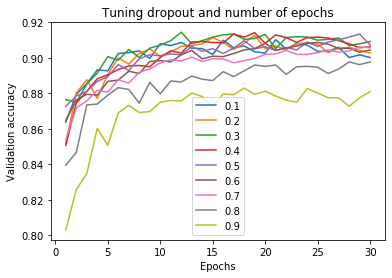

In [162]:
for i in range(0, len(dropouts)):
    plt.plot(range(1, 31),
             validation_accuracies[i],
             "C"+str(i), # "C0" is the first color in the palette, C1 the second etc
             label = str(dropouts[i]))

plt.xlabel("Epochs")
plt.ylabel('Validation accuracy')
plt.legend()
plt.title("Tuning dropout and number of epochs")
plt.show()

Cool. But *which* one is the best value?

In [163]:
# the following is the list of highest accuracy scores across epochs, for each dropout value
best_scores = list(map(max, validation_accuracies))
print(best_scores)

[0.9102500081062317, 0.9127500057220459, 0.9144999980926514, 0.9142500162124634, 0.9135000109672546, 0.9087499976158142, 0.90625, 0.8977500200271606, 0.8830000162124634]


In [164]:
# which dropout value had the best overall scores?
index = best_scores.index(max(best_scores))
print(dropouts[index])

0.3


In [167]:
# in which epoch?
validation_accuracies[index].index(max(best_scores)) + 1

12

What are the performance of this model on the test set?

In [183]:
# model
model = Sequential() # initialize
model.add(Dense(64, activation = "relu", input_dim = onehot_train.shape[1])) # dense layer with ReLU activation
model.add(Dropout(0.3)) # droput
model.add(Dense(1, activation = 'sigmoid')) # binary classification

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [184]:
# training
history = model.fit(onehot_train,
                    train_y,
                    epochs = 30,
                    batch_size = 32,
                    validation_split = 0.2,
                    verbose = 1)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
16000/16000 [==============================] - 2s 148us/step - loss: 0.3442 - accuracy: 0.8436 - val_loss: 0.2922 - val_accuracy: 0.8740
Epoch 2/30
16000/16000 [==============================] - 1s 87us/step - loss: 0.2698 - accuracy: 0.8771 - val_loss: 0.2806 - val_accuracy: 0.8750
Epoch 3/30
16000/16000 [==============================] - 1s 86us/step - loss: 0.2492 - accuracy: 0.8882 - val_loss: 0.2683 - val_accuracy: 0.8827
Epoch 4/30
16000/16000 [==============================] - 2s 150us/step - loss: 0.2349 - accuracy: 0.8960 - val_loss: 0.2665 - val_accuracy: 0.8827
Epoch 5/30
16000/16000 [==============================] - 2s 116us/step - loss: 0.2229 - accuracy: 0.9031 - val_loss: 0.2520 - val_accuracy: 0.8942
Epoch 6/30
16000/16000 [==============================] - 1s 86us/step - loss: 0.2125 - accuracy: 0.9079 - val_loss: 0.2456 - val_accuracy: 0.8960
Epoch 7/30
16000/16000 [==============================] - 1s 94us/

In [185]:
# predictions of the model on test data
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
pred = np.around(model.predict(onehot_test))
print("Accuracy={}".format(accuracy_score(test_y, pred)))
pr, re, f1, su = precision_recall_fscore_support(test_y, pred, average='macro')
print("Precision={}, Recall={}, F1-Score={}".format(pr, re, f1))

Accuracy=0.9119036732205457
Precision=0.8735550724949216, Recall=0.831825159208589, F1-Score=0.8503914648140878


### Exercise 3
What happens if the zeros used for padding are appended to the sequences instead of prepended?

In [195]:
# reset train_x and test_x to original definition
train_x = df_train.apply(lambda row: word_encoder(row.word, alphabet), axis = 1)
test_x = df_test.apply(lambda row: word_encoder(row.word, alphabet), axis = 1)

In [196]:
# padding
train_x = pad_sequences(train_x, padding = "post") # default is "pre"
test_x = pad_sequences(test_x, maxlen = train_x.shape[1], padding = "post")

In [197]:
# encoding
train_x_cat = to_categorical(train_x)
test_x_cat = to_categorical(test_x)

# flatten
onehot_train = train_x_cat.reshape(train_x_cat.shape[0], train_x_cat.shape[1]*train_x_cat.shape[2])
onehot_test = test_x_cat.reshape(test_x_cat.shape[0], test_x_cat.shape[1]*test_x_cat.shape[2])

In [198]:
# check
print(onehot_train.shape)
print(onehot_test.shape)

(20000, 961)
(6561, 961)


In [199]:
# tuning
validation_accuracies = []
for dropout_value in dropouts:
    print("Training with dropout={}...".format(dropout_value))
    # model
    model = Sequential() # initialize
    model.add(Dense(64, activation = "relu", input_dim = onehot_train.shape[1])) # dense layer with ReLU activation
    model.add(Dropout(dropout_value)) # droput
    model.add(Dense(1, activation = 'sigmoid')) # binary classification

    model.compile(loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
    history = model.fit(onehot_train,
              train_y,
              epochs = 30,
              batch_size = 32,
              validation_split = 0.2,
              verbose = 0)
    validation_accuracies.append(history.history["val_accuracy"])
print("Done!")

Training with dropout=0.1...
Training with dropout=0.2...
Training with dropout=0.3...
Training with dropout=0.4...
Training with dropout=0.5...
Training with dropout=0.6...
Training with dropout=0.7...
Training with dropout=0.8...
Training with dropout=0.9...
Done!


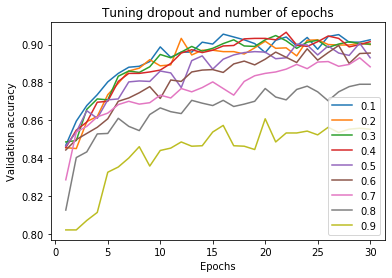

In [200]:
# visualize
for i in range(0, len(dropouts)):
    plt.plot(range(1, 31),
             validation_accuracies[i],
             "C"+str(i), # "C0" is the first color in the palette, C1 the second etc
             label = str(dropouts[i]))

plt.xlabel("Epochs")
plt.ylabel('Validation accuracy')
plt.legend()
plt.title("Tuning dropout and number of epochs")
plt.show()

In [202]:
# the following is the list of highest accuracy scores across epochs, for each dropout value
best_scores = list(map(max, validation_accuracies))
# which dropout value had the best overall scores?
index = best_scores.index(max(best_scores))
print(dropouts[index])
# in which epoch?
validation_accuracies[index].index(max(best_scores)) + 1

0.4


22

In [203]:
# model
model = Sequential() # initialize
model.add(Dense(64, activation = "relu", input_dim = onehot_train.shape[1])) # dense layer with ReLU activation
model.add(Dropout(0.4)) # droput
model.add(Dense(1, activation = 'sigmoid')) # binary classification

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
# training
history = model.fit(onehot_train,
                    train_y,
                    epochs = 30,
                    batch_size = 32,
                    validation_split = 0.2,
                    verbose = 1)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
16000/16000 [==============================] - 2s 119us/step - loss: 0.4020 - accuracy: 0.8219 - val_loss: 0.3547 - val_accuracy: 0.8468
Epoch 2/30
16000/16000 [==============================] - 2s 111us/step - loss: 0.3324 - accuracy: 0.8549 - val_loss: 0.3339 - val_accuracy: 0.8595
Epoch 3/30
16000/16000 [==============================] - 2s 95us/step - loss: 0.3090 - accuracy: 0.8643 - val_loss: 0.3167 - val_accuracy: 0.8618
Epoch 4/30
16000/16000 [==============================] - 1s 89us/step - loss: 0.2932 - accuracy: 0.8747 - val_loss: 0.3077 - val_accuracy: 0.8700
Epoch 5/30
16000/16000 [==============================] - 2s 94us/step - loss: 0.2801 - accuracy: 0.8773 - val_loss: 0.3031 - val_accuracy: 0.8665
Epoch 6/30
16000/16000 [==============================] - 2s 115us/step - loss: 0.2679 - accuracy: 0.8811 - val_loss: 0.2886 - val_accuracy: 0.8767
Epoch 7/30
16000/16000 [==============================] - 2s 101us

Evaluate the model on test data:

In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [204]:
# predictions of the model on test data
pred = np.around(model.predict(onehot_test))
# evaluation
print("Accuracy={}".format(accuracy_score(test_y, pred)))
pr, re, f1, su = precision_recall_fscore_support(test_y, pred, average='macro')
print("Precision={}, Recall={}, F1-Score={}".format(pr, re, f1))

Accuracy=0.9109891784788904
Precision=0.8650442287188196, Recall=0.8411756150172971, F1-Score=0.8523373377786521


Worse performance, but not by much. It's likely that the model learns something from the last three or four letters in a word (there are typical verb-endings and typical noun-endings in German). This information might be washed out by `post` padding.

### Exercise 4
Back to logistic regression. Train and evaluate a logistic regression model on the same data, and compare with results of the nn trained above.

In [219]:
from keras.regularizers import l2
# model
model = Sequential() # initialize
model.add(Dense(1, activation = 'sigmoid',
                   input_dim = onehot_train.shape[1],
                   kernel_regularizer = l2(0)))

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
# training
history = model.fit(onehot_train,
                    train_y,
                    epochs = 30,
                    batch_size = 32,
                    validation_split = 0.2,
                    verbose = 1)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
16000/16000 [==============================] - 1s 60us/step - loss: 0.4614 - accuracy: 0.8044 - val_loss: 0.4227 - val_accuracy: 0.8020
Epoch 2/30
16000/16000 [==============================] - 1s 60us/step - loss: 0.3958 - accuracy: 0.8112 - val_loss: 0.3924 - val_accuracy: 0.8198
Epoch 3/30
16000/16000 [==============================] - 1s 60us/step - loss: 0.3707 - accuracy: 0.8307 - val_loss: 0.3771 - val_accuracy: 0.8322
Epoch 4/30
16000/16000 [==============================] - 1s 76us/step - loss: 0.3562 - accuracy: 0.8410 - val_loss: 0.3705 - val_accuracy: 0.8320
Epoch 5/30
16000/16000 [==============================] - 1s 52us/step - loss: 0.3471 - accuracy: 0.8469 - val_loss: 0.3625 - val_accuracy: 0.8425
Epoch 6/30
16000/16000 [==============================] - 1s 54us/step - loss: 0.3406 - accuracy: 0.8498 - val_loss: 0.3595 - val_accuracy: 0.8407
Epoch 7/30
16000/16000 [==============================] - 1s 58us/ste

With a few manual tests we determined that no regularization yields better results.

In [220]:
# evaluation of the model on test data
pred = np.around(model.predict(onehot_test))
print("Accuracy={}".format(accuracy_score(test_y, pred)))
pr, re, f1, su = precision_recall_fscore_support(test_y, pred, average='macro')
print("Precision={}, Recall={}, F1-Score={}".format(pr, re, f1))

Accuracy=0.8510897729004725
Precision=0.7681266068347956, Recall=0.7145113650094652, F1-Score=0.735431286085378


Notably worse than previous results.

### Exercise 5
Recurrent neural networks. We train and tune a recurrent neural network using Gated Recurrent Unit (GRU), with `train_x` as defined at the beginning i.e. words as padded lists of integers but without one-hot-encoding the characters.

First of all, the data:

In [13]:
# reset train_x and test_x to original definition
train_x = df_train.apply(lambda row: word_encoder(row.word, alphabet), axis = 1)
test_x = df_test.apply(lambda row: word_encoder(row.word, alphabet), axis = 1)
# padding
train_x = pad_sequences(train_x, padding = "pre")
test_x = pad_sequences(test_x, maxlen = train_x.shape[1], padding = "pre")

In [14]:
train_x.shape

(20000, 31)

Next, we define and try out one possible hyperparameter configuration of the model:

In [15]:
from keras.layers import Embedding, GRU

In [16]:
# model
model = Sequential() # initialize

# embedding layer
model.add(Embedding(input_dim = len(alphabet)+2, # length of alphabet (plus unknown) plus one
                    input_length = train_x.shape[1], # length of each padded word
                    output_dim = 16, # length of embedded vector
                    mask_zero = True)) # the zeros in the padding are to be treated as special symbols
model.add(Dropout(0.3)) # droput

model.add(GRU(units = 32)) # GRU layer
model.add(Dropout(0.3)) # droput

model.add(Dense(1, activation = 'sigmoid')) # binary classification

# this as before
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 16)            512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 16)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                4704      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
_________________________________________________________________


In [18]:
# training
history = model.fit(train_x,
                    train_y,
                    epochs = 30,
                    batch_size = 32,
                    validation_split = 0.2,
                    verbose = 1)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
16000/16000 [==============================] - 12s 762us/step - loss: 0.4154 - accuracy: 0.8170 - val_loss: 0.3472 - val_accuracy: 0.8278
Epoch 2/30
16000/16000 [==============================] - 11s 695us/step - loss: 0.3369 - accuracy: 0.8394 - val_loss: 0.3236 - val_accuracy: 0.8435
Epoch 3/30
16000/16000 [==============================] - 11s 692us/step - loss: 0.3162 - accuracy: 0.8531 - val_loss: 0.3257 - val_accuracy: 0.8403
Epoch 4/30
16000/16000 [==============================] - 11s 673us/step - loss: 0.3050 - accuracy: 0.8562 - val_loss: 0.2977 - val_accuracy: 0.8568
Epoch 5/30
16000/16000 [==============================] - 11s 713us/step - loss: 0.2940 - accuracy: 0.8611 - val_loss: 0.3083 - val_accuracy: 0.8520
Epoch 6/30
16000/16000 [==============================] - 11s 708us/step - loss: 0.2830 - accuracy: 0.8684 - val_loss: 0.2799 - val_accuracy: 0.8702
Epoch 7/30
16000/16000 [==============================] -

Results seem already better than simple nn above, even with no tuning whatsoever.

Evaluate the model on test data as well:

In [20]:
# predictions of the model on test data
pred = np.around(model.predict(test_x))
# evaluation
print("Accuracy={}".format(accuracy_score(test_y, pred)))
pr, re, f1, su = precision_recall_fscore_support(test_y, pred, average='macro')
print("Precision={}, Recall={}, F1-Score={}".format(pr, re, f1))

Accuracy=0.9263831732967536
Precision=0.8903559110159086, Recall=0.8675418104354908, F1-Score=0.8783009710881744


Again, better results than tuned simple nn above.

We can try to tune the rnn as well, in which case there are several hyperparameters: output of embedding layer, dropout value after this layer, number of GRU units, dropout after this layer, number of epochs...? 

We use `keras-tuner`:

In [41]:
from tensorflow import keras # we need to import keras like this in order for it to work with keras-tuner
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

First, we wrap our rnn model above in a function which takes `hp` as argument, where `hp` is a variable where we sample hyperparameter values from:

In [74]:
def build_model(hp): # notice where hp is referred to in the following defintion
    # model
    model = keras.Sequential()

    # embedding layer
    model.add(layers.Embedding(input_dim = len(alphabet)+2,
                        input_length = train_x.shape[1],
                        output_dim = hp.Int("output_dim", # number of embedding output can range between 16 and 128
                                            min_value=16,
                                            max_value=128,
                                            step=32),
                        mask_zero = True))

    model.add(layers.Dropout(rate = hp.Choice("rate_1", # dropout can range between 0.1 and 0.5
                                              values = [0.1, 0.2, 0.3, 0.4, 0.5])))

    model.add(layers.GRU(units = hp.Int("units", # number of GRUnits can range between 32 and 128
                                        min_value=32,
                                        max_value=128,
                                        step=32)))

    model.add(layers.Dropout(rate = hp.Choice("rate_2", # dropout can range between 0.1 and 0.5
                                              values = [0.1, 0.2, 0.3, 0.4, 0.5])))

    model.add(layers.Dense(1, activation = 'sigmoid'))

    # this as before
    model.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])
    return(model)

Next, we initialize a tuner:

In [79]:
tuner = RandomSearch(build_model, # the function defined above
                     objective = "val_accuracy", # the metric to optimize
                     max_trials = 5, # total number of trials to test
                     executions_per_trial = 3, # how many models are built and fit in each trial
                     directory = "tuning",
                     project_name = "assignment5")

INFO:tensorflow:Reloading Oracle from existing project tuning\assignment5\oracle.json


In [77]:
tuner.search_space_summary()

Run the search:

In [80]:
tuner.search(train_x, train_y, epochs = 5, validation_split = 0.2, verbose = 0)

INFO:tensorflow:Oracle triggered exit


Evaluate best model found on test data:

In [87]:
best_model = tuner.get_best_models()[0]

In [88]:
# predictions of the model on test data
pred = np.around(best_model.predict(test_x))
# evaluation
print("Accuracy={}".format(accuracy_score(test_y, pred)))
pr, re, f1, su = precision_recall_fscore_support(test_y, pred, average='macro')
print("Precision={}, Recall={}, F1-Score={}".format(pr, re, f1))

Accuracy=0.9164761469288218
Precision=0.8752188193288963, Recall=0.8487822724648577, F1-Score=0.8610853019394897


Which is worse than the untuned rnn model above...🤔🤷